# Exploratory analysis of peer connectivity in mempool telementry experiment

## Set up

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(geosphere, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(ggraph, quietly=TRUE)
    require(igraph, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(maps, quietly=TRUE)
    require(RColorBrewer, quietly=TRUE)
    require(tidygraph, quietly=TRUE)
})

In [2]:
bauTime <- as.POSIXct("2025-11-22 02:00:00", tz = "UTC")

In [3]:
bauSlot <- 172210527

The previous plot shows that only two nodes ever received the transactions.

## Read and compute connectivity

In [4]:
outbounds <- fread("../mempool-measurements/outbounds.tsv.gz", stringsAsFactors=TRUE)
colnames(outbounds) <- c("Region", "Tx logged", "Local", "Remote", "Tx hash")
outbounds <- outbounds[, .(
    `Region`, 
    `Tx logged`, 
    `Local host`=sub(":.*$", "",`Local`)%>%as.factor, 
    `Local port`=sub(".*:", "", `Local`)%>%as.factor,
    `Remote host`=sub(":.*$", "",`Remote`%>%as.factor), 
    `Remote port`=sub(".*:", "", `Remote`%>%as.factor),
    `Tx hash`
)]
outbounds %>% summary

            Region          Tx logged                     
 ap-northeast-1: 368515   Min.   :2025-11-19 22:27:59.00  
 eu-central-1  :1445137   1st Qu.:2025-11-22 17:36:50.00  
 us-east-2     : 591678   Median :2025-11-24 00:51:10.00  
                          Mean   :2025-11-23 22:29:25.00  
                          3rd Qu.:2025-11-25 06:22:40.00  
                          Max.   :2025-11-26 15:01:21.00  
                                                          
          Local host      Local port     Remote host        Remote port       
 18.176.178.121: 368515   3001:2405330   Length:2405330     Length:2405330    
 18.218.69.112 : 591678                  Class :character   Class :character  
 52.28.55.26   :1445137                  Mode  :character   Mode  :character  
                                                                              
                                                                              
                                                      

In [5]:
connectivity <- outbounds[, .(`Tx count`=.N), .(`Region`, `Local host`, `Remote host`=as.factor(`Remote host`))]
connectivity %>% summary

            Region             Local host          Remote host  
 ap-northeast-1:327   18.176.178.121:327   104.131.122.73:   3  
 eu-central-1  :531   18.218.69.112 :311   109.228.150.84:   3  
 us-east-2     :311   52.28.55.26   :531   13.114.184.31 :   3  
                                           13.211.73.179 :   3  
                                           13.236.12.204 :   3  
                                           13.48.207.141 :   3  
                                           (Other)       :1151  
    Tx count    
 Min.   :    1  
 1st Qu.:  125  
 Median :  662  
 Mean   : 2058  
 3rd Qu.: 2082  
 Max.   :38075  
                

## Read and compute geography

In [6]:
remoteGeo <- fread("../mempool-measurements/reallyfreegeoip.tsv.gz", stringsAsFactors=TRUE)
remoteGeo %>% summary

             Remote    Longitude [deg]    Latitude [deg]  
 100.36.30.173  :  1   Min.   :-123.767   Min.   :-38.73  
 103.147.114.194:  1   1st Qu.: -73.968   1st Qu.: 37.75  
 103.73.64.137  :  1   Median :   8.567   Median : 48.20  
 104.131.122.73 :  1   Mean   :  -1.595   Mean   : 41.70  
 104.167.218.211:  1   3rd Qu.:  16.380   3rd Qu.: 50.48  
 104.225.220.71 :  1   Max.   : 174.768   Max.   : 69.63  
 (Other)        :818                                      

In [7]:
connectivityGeo <- connectivity[
    remoteGeo[, .(`Remote host`=as.factor(`Remote`), `Remote longitude [deg]`=`Longitude [deg]`, `Remote latitude [deg]`=`Latitude [deg]`)],
    on="Remote host",
    nomatch=0
][
    remoteGeo[, .(`Local host`=as.factor(`Remote`), `Local longitude [deg]`=`Longitude [deg]`, `Local latitude [deg]`=`Latitude [deg]`)],
    on="Local host",
    nomatch=0
]    
connectivityGeo %>% summary

            Region              Local host          Remote host  
 ap-northeast-1:327   52.28.55.26    :531   104.131.122.73:   3  
 eu-central-1  :531   18.176.178.121 :327   109.228.150.84:   3  
 us-east-2     :311   18.218.69.112  :311   13.114.184.31 :   3  
                      100.36.30.173  :  0   13.211.73.179 :   3  
                      103.147.114.194:  0   13.236.12.204 :   3  
                      103.73.64.137  :  0   13.48.207.141 :   3  
                      (Other)        :  0   (Other)       :1151  
    Tx count     Remote longitude [deg] Remote latitude [deg]
 Min.   :    1   Min.   :-123.767       Min.   :-38.73       
 1st Qu.:  125   1st Qu.: -74.010       1st Qu.: 37.75       
 Median :  662   Median :   6.861       Median : 48.20       
 Mean   : 2058   Mean   :  -1.714       Mean   : 41.70       
 3rd Qu.: 2082   3rd Qu.:  16.380       3rd Qu.: 50.48       
 Max.   :38075   Max.   : 174.768       Max.   : 69.63       
                                      

In [8]:
connectivityDistance <-
    connectivityGeo[, .(
        `Region`,
        `Local host`,
        `Remote host`,
        `Tx count`,
        `Distance [km]`=mapply(
            function(x1, y1, x2, y2) distHaversine(c(x1, y1), c(x2, y2))/1000, 
            `Local longitude [deg]`, 
            `Local latitude [deg]`,
            `Remote longitude [deg]`,
            `Remote latitude [deg]`
        )
    )]
connectivityDistance %>% summary

            Region              Local host          Remote host  
 ap-northeast-1:327   52.28.55.26    :531   104.131.122.73:   3  
 eu-central-1  :531   18.176.178.121 :327   109.228.150.84:   3  
 us-east-2     :311   18.218.69.112  :311   13.114.184.31 :   3  
                      100.36.30.173  :  0   13.211.73.179 :   3  
                      103.147.114.194:  0   13.236.12.204 :   3  
                      103.73.64.137  :  0   13.48.207.141 :   3  
                      (Other)        :  0   (Other)       :1151  
    Tx count     Distance [km]    
 Min.   :    1   Min.   :    0.0  
 1st Qu.:  125   1st Qu.:  768.4  
 Median :  662   Median : 6837.3  
 Mean   : 2058   Mean   : 5923.2  
 3rd Qu.: 2082   3rd Qu.: 9323.5  
 Max.   :38075   Max.   :18553.2  
                                  

## Histogram of peer distance

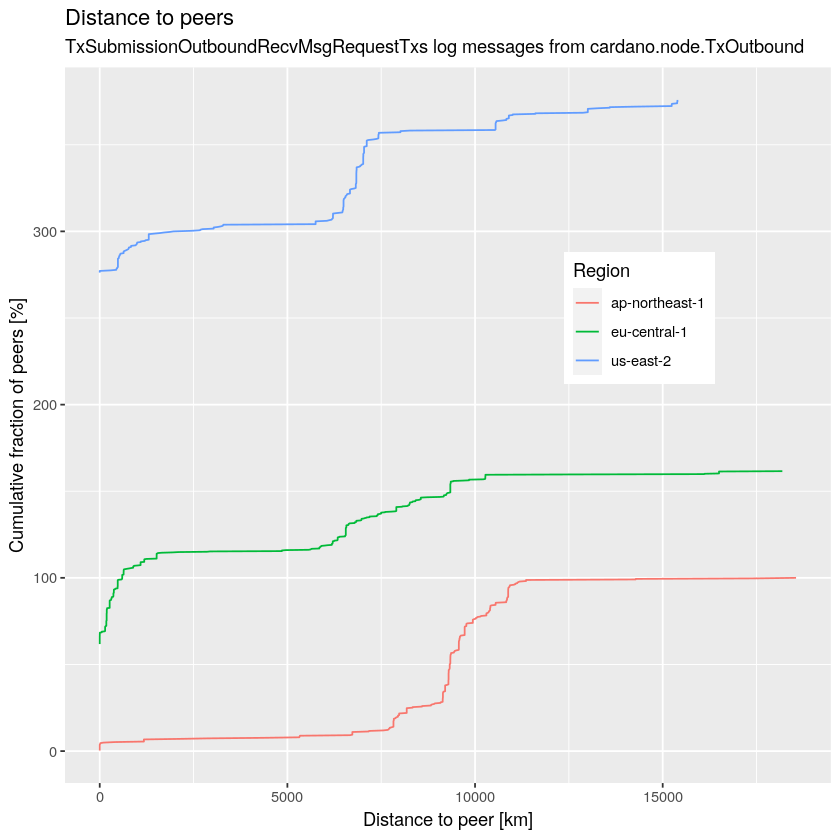

In [12]:
ggplot(
    connectivityDistance[order(`Region`, `Distance [km]`)][
        , 
        .(`Distance to peer [km]`=`Distance [km]`, `Cumulative fraction of peers [%]`=100*.I/.N), 
        .(`Region`)
    ],
    aes(x=`Distance to peer [km]`, y=`Cumulative fraction of peers [%]`, color=`Region`)
) +
    geom_line() +
    theme(legend.position = c(0.75, 0.65)
) +
    ggtitle(
        "Distance to peers",
        "TxSubmissionOutboundRecvMsgRequestTxs log messages from cardano.node.TxOutbound"
    )

In [10]:
ggsave("mpe-peer-distance-histogram.png", units="in", dpi=150, width=8, height=6)

In [11]:
ggsave("mpe-peer-distance-histogram.svg", units="in", dpi=150, width=8, height=6)

## Cumulative peer distance

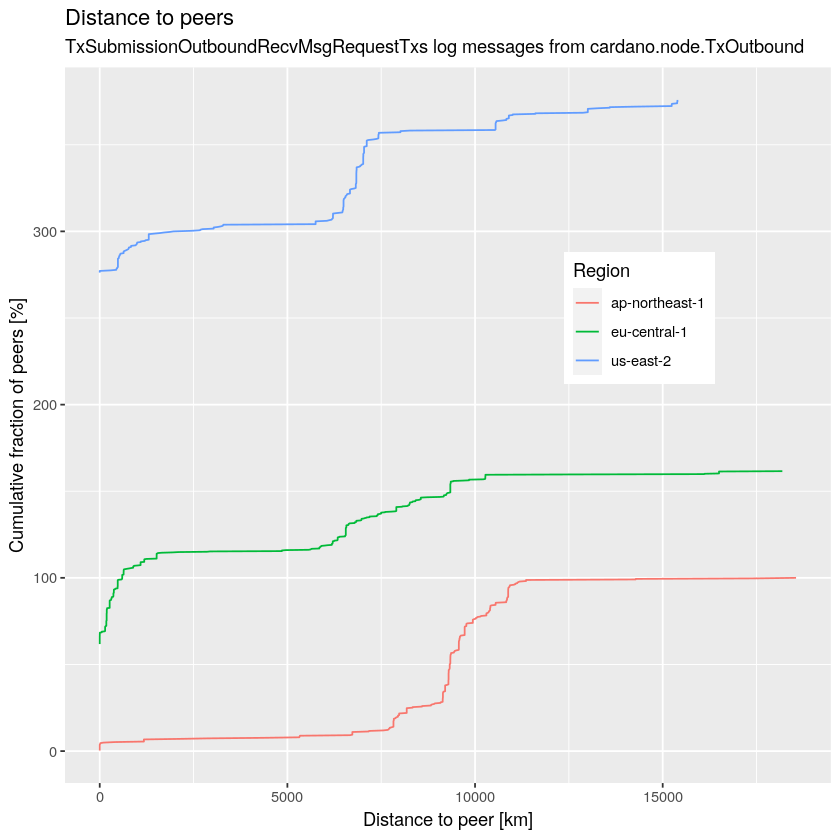

In [12]:
ggplot(
    connectivityDistance[order(`Region`, `Distance [km]`)][
        , 
        .(`Distance to peer [km]`=`Distance [km]`, `Cumulative fraction of peers [%]`=100*.I/.N), 
        .(`Region`)
    ],
    aes(x=`Distance to peer [km]`, y=`Cumulative fraction of peers [%]`, color=`Region`)
) +
    geom_line() +
    theme(legend.position = c(0.75, 0.65)
) +
    ggtitle(
        "Distance to peers",
        "TxSubmissionOutboundRecvMsgRequestTxs log messages from cardano.node.TxOutbound"
    )

In [13]:
ggsave("mpe-peer-distance-cumulative.png", units="in", dpi=150, width=8, height=6)

In [14]:
ggsave("mpe-peer-distance-cumulative.svg", units="in", dpi=150, width=8, height=6)